## Time concatenation analysis: demo 

In [1]:
# Import libraries
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
import mne
from mne.decoding import SPoC
mne.set_log_level(verbose='warning') #to avoid info at terminal
import pickle 
import sys
# from Utilities folder
sys.path.insert(1, './Utilities/icn_m1')
import os
sys.path.insert(1, './Utilities/')
from FilterBank import FilterBank
from ML_models import get_model

from collections import OrderedDict
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

In [2]:
# define settings
settings = {}
settings['data_path'] = 'YOUR_ADDRESS'
settings['num_patients'] = ['000'] # for this example we only use one subject
# subfolders indicates the session in this dataset
settings['subfolders']=[['ses-right']]  # this subject only has one session

In [3]:
# define functions
def append_time_dim(arr, y_, time_stamps):
    """
    apply added time dimension for the data array and label given time_stamps (with downsample_rate=100) in 100ms / need to check with 1375Hz
    @author: Timon Merk
    """
    time_arr = np.zeros([arr.shape[0]-time_stamps, int(time_stamps*arr.shape[1])])
    for time_idx, time_ in enumerate(np.arange(time_stamps, arr.shape[0])):
        for time_point in range(time_stamps):
            time_arr[time_idx, time_point*arr.shape[1]:(time_point+1)*arr.shape[1]] = arr[time_-time_point,:]
    return time_arr, y_[time_stamps:]     

In [4]:
# define some experiments and model parameters
laterality = ["CON", "IPS"]
signal = ["STN", "ECOG"]

cv = KFold(n_splits=5, shuffle=False)
spoc = SPoC(n_components=1, log=True, reg='oas', transform_into ='average_power', rank='full')
USED_MODEL = 3 # 3 == GLM with alpha 0.5

### Load the data from both modalities.
This data was already pre-processed, following these steps:
1. Epochs of 100 ms were extracted.
2. Band-passed filtered epoched data at 8 frequency bands ([4, 8], [8, 12], [13, 20], [20, 35], [13, 35], [60, 80], [90, 200], [60, 200])
3. The target variable was downsampled accordingly to the 100 ms epoch lenght.

If you want to run this code with your own data, please be sure of arranging your data in a 4d array as follows:
(epochs, channels, samples, frequency bands)

In [5]:
# get data
s = 0 # when working with all subjects, this is a for
subfolders=settings["subfolders"][s]
ss = 0 # when working with all subjects, this is a for, since there are subjects which have more than one session.
X_ECOG = [] # to append data
X_STN =[] 
Y_con = []
Y_ips = []
list_of_files_ecog = os.listdir(settings['data_path']+'ECOG') # list of files in the current directory
list_of_files_stn = os.listdir(settings['data_path']+'STN') 

file_name_ = 'ECOG_epochs_sub_' + settings['num_patients'][s] + '_sess_'+subfolders[ss][4:]

file_ecog = [each_file for each_file in list_of_files_ecog if each_file.startswith(file_name_)]
file_name_='STN_epochs_sub_' + settings['num_patients'][s] + '_sess_'+subfolders[ss][4:]

# only load data from runs in which both brain recording sites exit
file_stn= [each_file for each_file in list_of_files_stn if each_file.startswith(file_name_)]
idx_file = [f for f in file_stn if list(set() & set(file_ecog))]
matching_stn = [f for f in file_stn if any(f[4:] in xs for xs in file_ecog)]
matching_ecog = [f for f in file_ecog if any(f[4:] in xs for xs in file_stn)]

if len(matching_ecog) != len(matching_stn):
    raise('Error loading data')

for e in range(len(matching_ecog)):
    with open(settings['data_path'] +'ECOG/' + matching_ecog[e], 'rb') as handle:
        sub_ = pickle.load(handle)    
        data = sub_['epochs']
        X_ECOG.append(data)
        label_ips = sub_['label_ips']
        label_con = sub_['label_con']
        Y_con.append(label_con)
        Y_ips.append(label_ips)
    with open(settings['data_path'] +'STN/' + matching_stn[e], 'rb') as handle:
        sub_ = pickle.load(handle)
        data = sub_['epochs']
        X_STN.append(data)           

X_ECOG = np.concatenate(X_ECOG, axis=0)
X_STN = np.concatenate(X_STN, axis=0)
Y_con = np.concatenate(Y_con, axis=0)
Y_ips = np.concatenate(Y_ips, axis=0)  

In [6]:
# print data shape
print('The shape of the ECoG data is:\n(epochs, channels, samples, frequency bands):\n' + str(X_ECOG.shape))
print('The shape of the STN-LFP data is:\n(epochs, channels, samples, frequency bands):\n' + str(X_STN.shape))


The shape of the ECoG data is:
(epochs, channels, samples, frequency bands):
(2810, 6, 1001, 8)
The shape of the STN-LFP data is:
(epochs, channels, samples, frequency bands):
(2810, 3, 1001, 8)


### Run the experiment!
(and be patient, it can take a time!)

In [7]:
# run the experiment for every type of signal, time concatenation window and laterality
for m, eeg in enumerate(signal):
    # declare saving variable
    # for the purpose of this example we save some of them, but here you can define as many saving variables as you want to!
    Ypre_tr = OrderedDict()
    score_tlag = OrderedDict()
    Ypre_te = OrderedDict()
    score_te = OrderedDict()
    Label_tr = OrderedDict()
    Label_te = OrderedDict()
    if eeg == "ECOG":
        X = X_ECOG
    else:
        X = X_STN
    print('RUNNIN SUBJECT_'+ settings['num_patients'][s]+ '_SESS_'+ str(subfolders[ss]) + '_SIGNAL_' + eeg)
    for ll, mov in enumerate(laterality):
        score_tlag[mov] = []
        score_te[mov] = []
        Ypre_tr[mov] = []
        Ypre_te[mov] = []
        Label_tr[mov] = []
        Label_te[mov] = []
        print("training %s" %mov)
        for t in range(1,6): # for the sake of this example we set the number of time-lags to 5
            print("time_lag %s" %t)
            score_aux = []   
            if ll == 0:
                label = Y_con
            else:
                label = Y_ips

            features = FilterBank(estimator=spoc)

            for train_index, test_index in cv.split(label):
                Ztr, Zte = label[train_index], label[test_index]
                gtr = features.fit_transform(X[train_index], Ztr)
                gte = features.transform(X[test_index])


                dat_tr, label_tr = append_time_dim(gtr, Ztr,time_stamps=t)
                dat_te, label_te = append_time_dim(gte, Zte,time_stamps=t)

                Label_te[mov].append(label_te)
                Label_tr[mov].append(label_tr)

                clf, optimizer = get_model(USED_MODEL, x=dat_tr, y=label_tr)

                scaler = StandardScaler()
                scaler.fit(dat_tr)
                dat_tr = scaler.transform(dat_tr)
                dat_te = scaler.transform(dat_te)


                clf.fit(dat_tr, label_tr)
                Ypre_te[mov].append(clf.predict(dat_te))
                Ypre_tr[mov].append(clf.predict(dat_tr))
                # in the sklearn implementation r2 can be negative. We set negatives r2 to zero
                r2_te = r2_score(label_te, clf.predict(dat_te))
                # r2 in testing
                if r2_te < 0: r2_te = 0
                score_te[mov].append(r2_te)
                
                score_aux.append(r2_te)
            score_tlag[mov].append(np.mean(score_aux))
    if eeg=='ECOG':
        scores_ecog=score_tlag
    else:
        scores_stn=score_tlag
    del score_tlag, X  

RUNNIN SUBJECT_000_SESS_ses-right_SIGNAL_STN
training CON
time_lag 1
time_lag 2
time_lag 3
time_lag 4
time_lag 5
training IPS
time_lag 1
time_lag 2
time_lag 3
time_lag 4
time_lag 5
RUNNIN SUBJECT_000_SESS_ses-right_SIGNAL_ECOG
training CON
time_lag 1
time_lag 2
time_lag 3
time_lag 4
time_lag 5
training IPS
time_lag 1
time_lag 2
time_lag 3
time_lag 4
time_lag 5


### Let's visualize the results

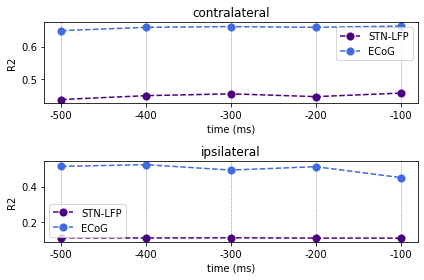

In [10]:
#Plot mean R2 at each time window
time= ["-100", "-200", "-300", "-400", "-500"][::-1]
name_laterality=["contralateral", "ipsilateral"]
name_signal=["STN-LFP", "ECoG"]

colors=['indigo', 'royalblue']
x = np.arange(1,6,1)
fig, ax = plt.subplots(nrows=2)
for ll, mov in enumerate(laterality):
    for m, eeg in enumerate(signal):
        if eeg == 'ECOG':
            scores=scores_ecog
        else:
            scores=scores_stn
        scores_ = scores[mov]
        scores_ = scores_[::-1]
        ax[ll].plot(x,scores_, fillstyle='full', markeredgewidth=0.1,  marker='o', markersize=8, 
                    markerfacecolor=colors[m],
                    linestyle='--', color=colors[m],
                    label=name_signal[m])
        
    ax[ll].set_ylabel("R2")
    ax[ll].set_xlabel("time (ms)")
    ax[ll].set_title(name_laterality[ll])
    ax[ll].grid(color='gray', linestyle='--', linewidth=0.5, axis='x')
    ax[ll].set_xticks(x)
    ax[ll].set_xticklabels(time)
    ax[ll].legend()
    plt.tight_layout()

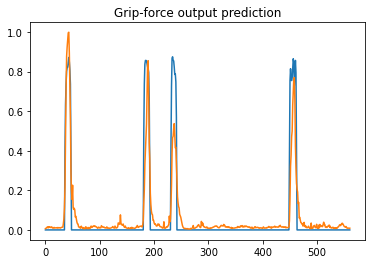

In [9]:
# plot one example of the predicted output
# For the contralateral side
fig, ax = plt.subplots()
ax.plot(Label_te['CON'][3][:700], label='True')
ax.plot(Ypre_te['CON'][3][:700], label='Predicted')
ax.set_title('Grip-force output prediction');

Although this is only one subject of the dataset, we can see here that there is no impact in movement decoding when adding more time-windows spatio-spectral features to GLM 